In [ ]:
# importing required libraries
import pandas as pd
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
from os import listdir
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.applications import VGG16
from tensorflow.keras.optimizers import Adam


In [ ]:
!pip install opendatasets
import opendatasets as od

# {"username":"shettyrakesh","key":"bb417cb394d7523d26269c13aca05ea1"}

od.download("https://www.kaggle.com/datasets/vishnuoum/medicinal-plant-dataset-augmented?select=data")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shettyrakesh
Your Kaggle Key: ··········


100%|██████████| 1.31G/1.31G [00:18<00:00, 77.0MB/s]


In [ ]:
# Set the path to your dataset directory
dataset_dir = "/content/medicinal-plant-dataset-augmented/data"

# Set the path where you want to store your training and testing data
train_dir = "/content/train"
test_dir = "/content/test"
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Lists to store file paths and corresponding labels
file_paths = []
labels = []

# Iterate over each plant directory and collect file paths and labels
for plant_category in os.listdir(dataset_dir):
    plant_path = os.path.join(dataset_dir, plant_category)
    if os.path.isdir(plant_path):
        for img_file in os.listdir(plant_path):
            file_paths.append(os.path.join(plant_path, img_file))
            labels.append(plant_category)

# Split the dataset into training and testing sets
train_files, test_files, train_labels, test_labels = train_test_split(file_paths, labels, test_size=0.2, random_state=0)

# Copy training images to the training directory
for file, label in zip(train_files, train_labels):
    destination = os.path.join(train_dir, label)
    os.makedirs(destination, exist_ok=True)
    shutil.copy(file, destination)

# Copy testing images to the testing directory
for file, label in zip(test_files, test_labels):
    destination = os.path.join(test_dir, label)
    os.makedirs(destination, exist_ok=True)
    shutil.copy(file, destination)

print("Dataset split into training and testing data successfully.")

Dataset split into training and testing data successfully.


In [ ]:
# fitting the CNN to the image with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.8, 1.2],  # Adjust brightness between 0.8 and 1.2
    zoom_range=[0.8, 1.2],         # Randomly zoom in or out
    rotation_range=20,             # Randomly rotate images up to 20 degrees
    shear_range=0.2,               # Apply random shear transformation
    horizontal_flip=True,          # Randomly flip images horizontally
    vertical_flip=True             # Randomly flip images vertically
)

# Use the same test_datagen
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Generating image for train set
training_set = train_datagen.flow_from_directory("/content/train",
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

# generating test data set
test_set = test_datagen.flow_from_directory(
    "/content/test",
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

Found 11504 images belonging to 30 classes.
Found 2876 images belonging to 30 classes.


In [ ]:
# Load the pre-trained VGG16 model without the top (fully connected) layers
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

In [ ]:
# # Freeze the layers of VGG16 so they are not trainable
# for layer in vgg16.layers:
#     layer.trainable = False

In [ ]:
# Add custom fully connected layers on top of VGG16
model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=len(training_set.class_indices), activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(
    training_set,
    steps_per_epoch=len(training_set),
    epochs=20,
    validation_data=test_set,
    validation_steps=len(test_set)
)

Epoch 1/20
360/360 [==============================] - 90s 234ms/step - loss: 0.8677 - accuracy: 0.9569 - val_loss: 0.5043 - val_accuracy: 0.9812
Epoch 2/20
360/360 [==============================] - 84s 235ms/step - loss: 0.4468 - accuracy: 0.9706 - val_loss: 0.7035 - val_accuracy: 0.8905
Epoch 3/20
360/360 [==============================] - 75s 208ms/step - loss: 0.3487 - accuracy: 0.9659 - val_loss: 0.2871 - val_accuracy: 0.9732
Epoch 4/20
360/360 [==============================] - 73s 203ms/step - loss: 0.2315 - accuracy: 0.9781 - val_loss: 0.2468 - val_accuracy: 0.9677
Epoch 5/20
360/360 [==============================] - 73s 203ms/step - loss: 0.2085 - accuracy: 0.9748 - val_loss: 0.3099 - val_accuracy: 0.9492
Epoch 6/20
360/360 [==============================] - 84s 235ms/step - loss: 0.1783 - accuracy: 0.9772 - val_loss: 0.2200 - val_accuracy: 0.9638
Epoch 7/20
360/360 [==============================] - 74s 206ms/step - loss: 0.1347 - accuracy: 0.9833 - val_loss: 0.1374 - val_ac

In [ ]:
# Evaluate training accuracy
train_accuracy = model.evaluate(training_set)[1]
print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

# Evaluate testing accuracy
test_accuracy = model.evaluate(test_set)[1]
print(f'Testing Accuracy: {test_accuracy * 100:.2f}%')

360/360 [==============================] - 60s 167ms/step - loss: 0.1812 - accuracy: 0.9664
Training Accuracy: 96.64%
90/90 [==============================] - 10s 113ms/step - loss: 0.2200 - accuracy: 0.9583
Testing Accuracy: 95.83%


In [ ]:
from tensorflow.keras.models import load_model
model.save("/content/drive/MyDrive/saved  models/plant_classification_with_augmentation_relu.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model=load_model("/content/drive/MyDrive/saved  models/plant_classification_with_augmentation_testaccc98%.h5")

90/90 [==============================] - 14s 152ms/step


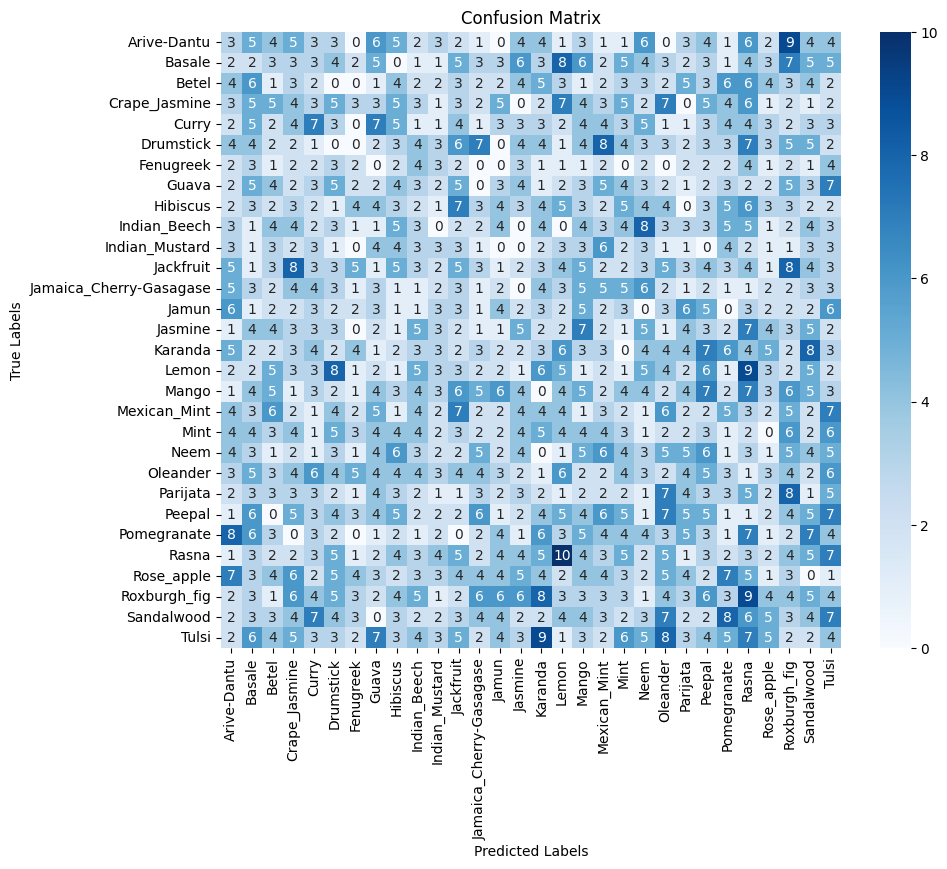

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# Get predictions for the test set
predictions = model.predict(test_set, steps=len(test_set))
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels for the test set
true_classes = test_set.classes

# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
# conf_matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=training_set.class_indices.keys(), yticklabels=training_set.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 1s 836ms/step


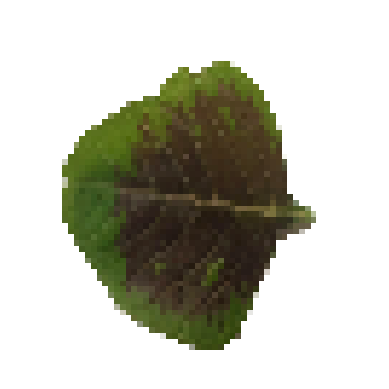

Prediction: Arive-Dantu


In [ ]:
from keras.preprocessing import image

def predict_and_plot(image_path, model, class_indices):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(64, 64))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # Make a prediction
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    predicted_class = list(class_indices.keys())[predicted_class_index]

    # Plot the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Print the prediction
    print("Prediction:", predicted_class)

# Example usage:
predict_and_plot("/content/train/Arive-Dantu/__0_1104004.png", model, training_set.class_indices)

1/1 [==============================] - 0s 19ms/step


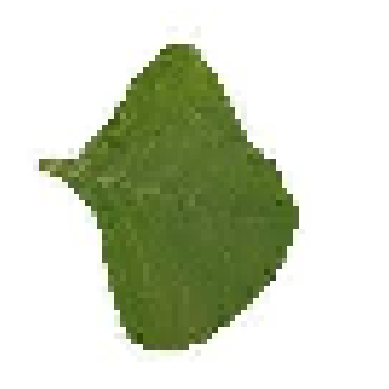

Prediction: Arive-Dantu


In [ ]:
# Example usage:
predict_and_plot("/content/arive-dantu.jpeg", model, training_set.class_indices)

1/1 [==============================] - 0s 21ms/step


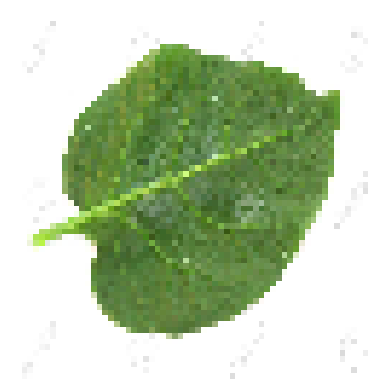

Prediction: Basale


In [ ]:
# Example usage:
predict_and_plot("/content/leaf-of-basella-alba.jpg", model, training_set.class_indices)

1/1 [==============================] - 0s 75ms/step


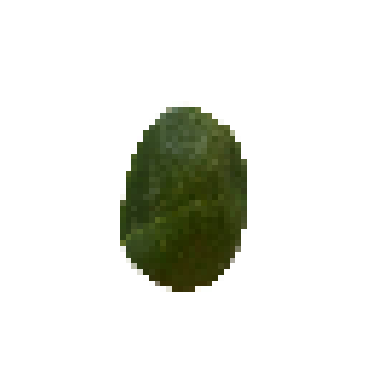

Prediction: Drumstick


In [ ]:
# Example usage:
predict_and_plot("/content/test/Drumstick/__12_214087.png", model, training_set.class_indices)